<a href="https://colab.research.google.com/github/tpgus2603/ImageCaptioning/blob/main/transformer3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install evaluate
import nltk
from PIL import Image
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd
import re
import torch
from datasets import Dataset
from transformers import VisionEncoderDecoderModel, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback, default_data_collator
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import pipeline
import nltk

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Vision Transformer (ViT) model and GPT-2 model
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(image_encoder_model, text_decode_model)
model.to(device)

# Load feature extractor and tokenizer for the respective models
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)
tokenizer.pad_token = tokenizer.eos_token

# Set model configurations
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.max_length = 20
model.config.min_length = 6
model.config.length_penalty = 1.3
model.config.num_beams = 3

# Define paths for the Flickr8k dataset
CAPTIONS_FILE = '/content/drive/MyDrive/kaggle/input/flickr8k/captions.txt'
IMAGES_DIR = '/content/drive/MyDrive/kaggle/input/flickr8k/Images'

# Load the captions file into a pandas DataFrame
df = pd.read_csv(CAPTIONS_FILE)
df['image'] = df['image'].apply(lambda x: f'{IMAGES_DIR}/{x}')

In [4]:
# 데이터프레임의 길이 계산
total_length = len(df)

# 4,000개 데이터로 프리트레인, 나머지 4,000개로 파인튠
pretrain_size = 4000
finetune_size = total_length - pretrain_size

# 데이터프레임 분할
pretrain_df = df.iloc[:pretrain_size, :]
finetune_df = df.iloc[pretrain_size:pretrain_size + 4000, :]

# 파인튜닝 데이터셋을 학습, 검증, 테스트로 나누기 (8:1:1 비율)
finetune_train_size = int(len(finetune_df) * 0.8)
finetune_val_size = int(len(finetune_df) * 0.1)
finetune_test_size = len(finetune_df) - finetune_train_size - finetune_val_size

finetune_train_df = finetune_df.iloc[:finetune_train_size, :]
finetune_val_df = finetune_df.iloc[finetune_train_size:finetune_train_size + finetune_val_size, :]
finetune_test_df = finetune_df.iloc[finetune_train_size + finetune_val_size:, :]

# 프리트레인, 파인튜닝 학습, 검증, 테스트 데이터셋 변환
processed_pretrain = Dataset.from_pandas(pretrain_df)
processed_finetune_train = Dataset.from_pandas(finetune_train_df)
processed_finetune_val = Dataset.from_pandas(finetune_val_df)
processed_finetune_test = Dataset.from_pandas(finetune_test_df)

class Flickr8kDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, feature_extractor, tokenizer, max_target_length=128):
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]['image']
        caption = self.dataset[idx]['caption']

        # Load the image and preprocess it using the feature extractor
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        encoder_input = self.feature_extractor(images=image, return_tensors="pt")  # Use PyTorch tensors

        # Tokenize the caption
        labels = self.tokenizer(caption, max_length=self.max_target_length, padding="max_length", truncation=True, return_tensors="pt")

        return {"labels": labels.input_ids.flatten(), "pixel_values": encoder_input.pixel_values.squeeze(0)}

# Create PyTorch Datasets for pretraining and finetuning
pretrain_data = Flickr8kDataset(processed_pretrain, feature_extractor, tokenizer)
finetune_train_data = Flickr8kDataset(processed_finetune_train, feature_extractor, tokenizer)
finetune_val_data = Flickr8kDataset(processed_finetune_val, feature_extractor, tokenizer)
finetune_test_data = Flickr8kDataset(processed_finetune_test, feature_extractor, tokenizer)


In [3]:
print(f"Splits:\n\t- Train-size:{len(pretrain_df)}\n\t- Val-size:{len(finetune_train_df)}\n\t- Test-size:{len(finetune_val_df)}")

Splits:
	- Train-size:4000
	- Val-size:3200
	- Test-size:400


In [5]:
# Define pretraining arguments
pretrain_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    num_train_epochs=3,
    eval_steps=1000,
    save_steps=2000,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    output_dir="/pretrain_results"
)

# 메트릭 함수 정의
def compute_metrics(eval_preds):
    metric = evaluate.load("rouge")
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]
    return preds, labels

# Custom Callback 정의
class CustomCallback(transformers.TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        train_loss = next((item['loss'] for item in state.log_history if 'loss' in item), None)
        eval_loss = next((item['eval_loss'] for item in state.log_history if 'eval_loss' in item), None)
        print(f"Epoch {state.epoch}: Train Loss = {train_loss}, Eval Loss = {eval_loss}")


# Create the pretraining trainer
pretrain_trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=pretrain_args,
    compute_metrics=compute_metrics,
    train_dataset=pretrain_data,
    data_collator=default_data_collator
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
# Pretrain the model
pretrain_trainer.train()

# Save the pretrained model
model.save_pretrained("/content/drive/MyDrive/pretrained_model")
tokenizer.save_pretrained("/content/drive/MyDrive/pretrained_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Some non-default ge

('./pretrained_model/tokenizer_config.json',
 './pretrained_model/special_tokens_map.json',
 './pretrained_model/vocab.json',
 './pretrained_model/merges.txt',
 './pretrained_model/added_tokens.json',
 './pretrained_model/tokenizer.json')

[링크 텍스트](https://)

In [8]:
# Save the pretrained model
model.save_pretrained("/content/drive/MyDrive//pretrained_model")
tokenizer.save_pretrained("/content/drive/MyDrive/pretrained_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('/content/drive/MyDrive/pretrained_model/tokenizer_config.json',
 '/content/drive/MyDrive/pretrained_model/special_tokens_map.json',
 '/content/drive/MyDrive/pretrained_model/vocab.json',
 '/content/drive/MyDrive/pretrained_model/merges.txt',
 '/content/drive/MyDrive/pretrained_model/added_tokens.json',
 '/content/drive/MyDrive/pretrained_model/tokenizer.json')

In [6]:
# Load pretrained model for finetuning
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/pretrained_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/pretrained_model")
model.to(device)

# 훈련 인자 설정
finetune_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",  # 각 에폭 후 평가 수행
    logging_strategy="epoch",     # 각 에폭 후 로깅 수행
    num_train_epochs=50,  # 최대 에폭 수를 충분히 크게 설정
    eval_steps=1000,
    save_steps=2000,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    remove_unused_columns=False,
    output_dir="/content/drive/MyDrive/finetune_results",
    logging_dir="/content/drive/MyDrive/logs",  # 로그 저장 경로 설정
    save_total_limit=3
)

# EarlyStoppingCallback 설정
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# Trainer 생성
finetune_trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=finetune_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    callbacks=[early_stopping, CustomCallback()]
)

# Finetune the model
finetune_trainer.train()

# Save the finetuned model
model.save_pretrained("/content/drive/MyDrive/finetuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_model")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Some non-default ge

('/content/drive/MyDrive/finetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/finetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/finetuned_model/vocab.json',
 '/content/drive/MyDrive/finetuned_model/merges.txt',
 '/content/drive/MyDrive/finetuned_model/added_tokens.json',
 '/content/drive/MyDrive/finetuned_model/tokenizer.json')

In [ ]:
# Load test dataset
test_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="no",
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    output_dir="/content/drive/MyDrive/test_results"
)

# Create the trainer for testing
test_trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=test_args,
    eval_dataset=finetune_test_data,
    data_collator=default_data_collator
)

# Predict on the test dataset
predictions = test_trainer.predict(finetune_test_data)

!pip install git+https://github.com/salaniz/pycocoevalcap

from pycocoevalcap.cider.cider import Cider



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(




Image 0 --> 2316097768_ef662f444b


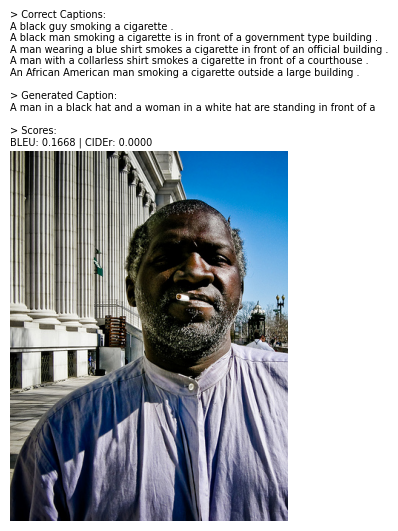



Image 1 --> 2317714088_bcd081f926




Image 2 --> 2318502106_33f2e4b4fc




Image 3 --> 2318659263_c24005a5cb




Image 4 --> 2318721455_80c6644441




Image 5 --> 2319087586_919472310f


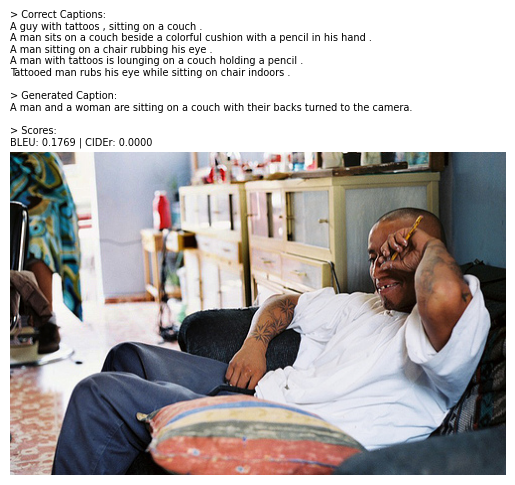



Image 6 --> 2319175397_3e586cfaf8




Image 7 --> 2319197581_94f807b204


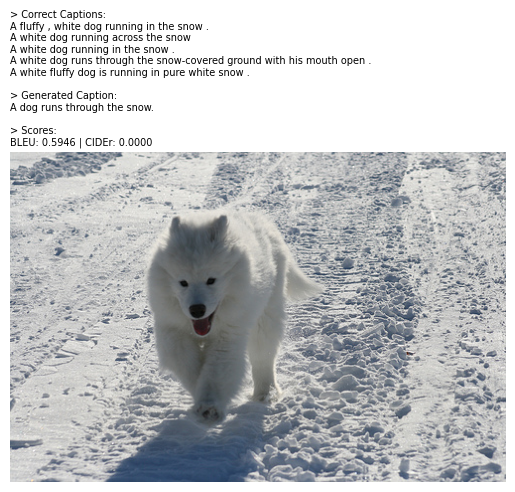



Image 8 --> 2319808437_bbbdc317c0


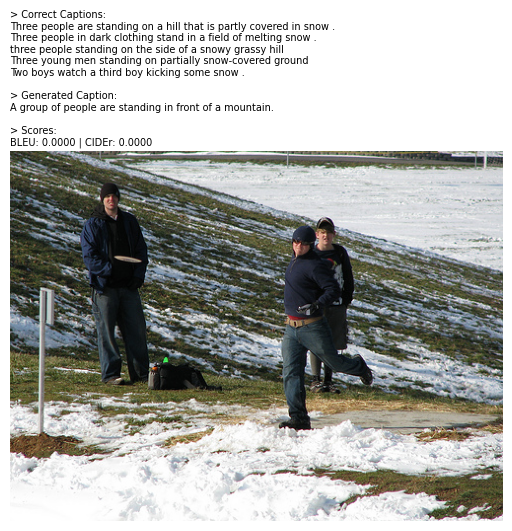



Image 9 --> 2320125735_27fe729948


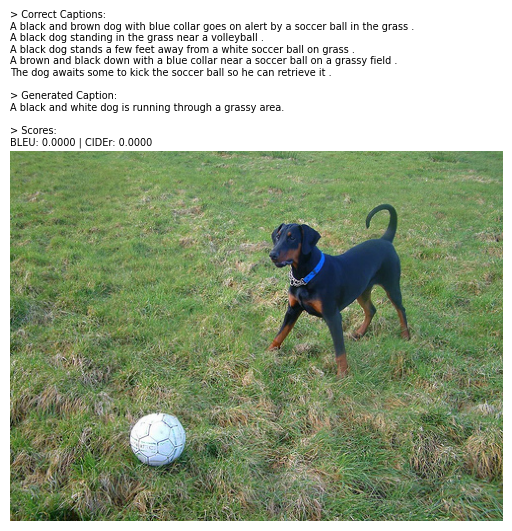

In [19]:
# 이미지 캡셔닝 파이프라인 생성
image_captioner = pipeline("image-to-text", model=model, tokenizer=tokenizer, feature_extractor=feature_extractor)

# Function to display images and their captions
def image_display(filepath, correct_caps, gen_caption, bleu_score, cider_score, font_size, dpi, save_img):
    img_color = cv2.imread(filepath, 1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))

    correct_caps_string = f"> Correct Captions:\n{correct_caps}"
    generated_caption_string = f"> Generated Caption:\n{gen_caption[0]['generated_text']}"
    scores_string = f"> Scores:\nBLEU: {bleu_score:.4f} | CIDEr: {cider_score:.4f}"

    title_string = f"{correct_caps_string}\n\n{generated_caption_string}\n\n{scores_string}"
    plt.title(title_string, fontsize=font_size, wrap=True, loc='left')

    if save_img:
        plt.savefig(f"{os.path.splitext(os.path.basename(filepath))[0]}_generation", bbox_inches='tight', dpi=dpi)
    plt.show()

# Function to compute BLEU score
def compute_bleu(predictions, references):
    bleu_metric = evaluate.load("bleu")
    results = bleu_metric.compute(predictions=predictions, references=references)
    return results['bleu']

# Function to compute CIDEr score
def compute_cider(predictions, references):
    cider_metric = Cider()
    cider_scores, _ = cider_metric.compute_score(references, predictions)
    return cider_scores

# Function to compute BLEU and CIDEr scores separately
def get_scores(correct_caps, gen_caption):
    # Ensure correct_caps is a list of strings
    correct_caps_list = correct_caps.split("\n")

    # Ensure gen_caption is a string
    predictions = [gen_caption]

    # Compute BLEU score
    bleu_score = compute_bleu(predictions, [correct_caps_list])

    # Prepare data for CIDEr score computation
    references = {0: correct_caps_list}
    preds = {0: [gen_caption]}

    # Compute CIDEr score
    cider_score = compute_cider(preds, references)

    return bleu_score, cider_score

# Function to generate captions for an image and display them along with their BLEU and CIDEr scores
def get_caption_for_image(filepath, correct_caps, font_size, dpi=300, save_img=False):
    gen_caption = image_captioner(filepath)
    bleu_score, cider_score = get_scores(correct_caps, gen_caption[0]['generated_text'])
    image_display(filepath, correct_caps, gen_caption, bleu_score, cider_score, font_size, dpi, save_img)

# Group test data by image
grouped_test_df = finetune_test_df.groupby('image')['caption'].agg(lambda x: '\n'.join(x)).reset_index()
grouped_test_ds = Dataset.from_pandas(grouped_test_df)

# Generate captions for a few example images and display the results
examples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in examples:
    instance = grouped_test_ds.__getitem__(i)
    image_path = instance['image']
    caption = instance['caption']
    print(f"\n\nImage {i} --> {os.path.splitext(os.path.basename(image_path))[0]}")
    get_caption_for_image(image_path, caption, font_size=7, dpi=500, save_img=True)
